In [13]:
import os
import pandas as pd
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

def merge_stock_data(stock_dir):
    """Merge all bbo and trade files for a single stock and save the result."""
    bbo_dir = os.path.join(stock_dir, 'bbo')
    trade_dir = os.path.join(stock_dir, 'trade')
    
    # Ensure subdirectories exist
    if not os.path.exists(bbo_dir) or not os.path.exists(trade_dir):
        print(f"Skipping {stock_dir}: Missing 'bbo' or 'trade' subdirectories.")
        return None
    
    daily_dfs = []
    
    # Get sorted list of files in both directories
    bbo_files = sorted(os.listdir(bbo_dir))
    trade_files = sorted(os.listdir(trade_dir))
    
    # Match files by name (assuming they correspond, e.g., '1.csv', '2.csv')
    for bbo_file, trade_file in zip(bbo_files, trade_files):
        bbo_path = os.path.join(bbo_dir, bbo_file)
        trade_path = os.path.join(trade_dir, trade_file)
        
        if os.path.isfile(bbo_path) and os.path.isfile(trade_path):
            # Load the files
            bbo_df = pd.read_parquet(bbo_path)
            trade_df = pd.read_parquet(trade_path)
            
            # Merge on a common key (adjust the key column name as necessary)
            merged_df = pd.merge(bbo_df, trade_df, on='xltime', how='inner')  # Replace 'timestamp' if needed

            # Check if 'xltime' column exists and transform it to datetime
            if 'xltime' in merged_df.columns:
                merged_df['datetime'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(merged_df['xltime'], unit='D')
            else:
                print("'xltime' column not found in the dataset.")

            aggregated_df = (
                merged_df.groupby(['datetime'])  # Grouping by 'datetime' or any key to identify duplicates
                .apply(lambda g: pd.Series({
                    'weighted_bid_price': (g['bid-price'] * g['bid-volume']).sum() / g['bid-volume'].sum(),
                    'total_bid_quantity': g['bid-volume'].sum(),
                    'max_bid_quantity': g['bid-volume'].max(),
                    'weighted_ask_price': (g['ask-price'] * g['ask-volume']).sum() / g['ask-volume'].sum(),
                    'total_ask_quantity': g['ask-volume'].sum(),
                    'max_ask_quantity': g['ask-volume'].max(),
                    'total_trade_volume': g['trade-volume'].sum(),


                }))
                .reset_index()
            )
            
            # Append the merged DataFrame to the list
            daily_dfs.append(aggregated_df)
        else:
            print(f"Skipping unmatched files: {bbo_file}, {trade_file}")
    
    # Concatenate all daily DataFrames into one for the stock
    if daily_dfs:
        stock_merged_df = pd.concat(daily_dfs, ignore_index=True)
        
        # Save the merged DataFrame in the stock's folder
        output_path = os.path.join(stock_dir, 'merged_data.csv')  # Save as CSV
        stock_merged_df.to_csv(output_path, index=False)
        print(f"Merged data saved for stock: {os.path.basename(stock_dir)}")
    else:
        print(f"No data to merge for stock: {os.path.basename(stock_dir)}")

def process_all_stocks(base_dir):
    """Process all stocks in the base directory."""
    for stock in sorted(os.listdir(base_dir)):
        stock_dir = os.path.join(base_dir, stock)
        if os.path.isdir(stock_dir):
            print(f"Processing stock: {stock}")
            merge_stock_data(stock_dir)
        else:
            print(f"Skipping non-directory item: {stock}")

# Example usage
base_directory = "/Users/othmaneio/Documents/financial_big_data/data"  # Replace with the path to your stock directories
process_all_stocks(base_directory)


Skipping non-directory item: .DS_Store
Processing stock: A


KeyboardInterrupt: 

In [8]:
!pip install polars


     |████████████████████████████████| 33.0 MB 3.9 kB/s eta 0:00:011     |█████████████████▊              | 18.3 MB 14.0 MB/s eta 0:00:02MB 11.1 MB/s eta 0:00:01


In [18]:
import polars as pl
import os

def process_stock_with_polars(stock_dir):
    """Merge bbo and trade files for a single stock using Polars and perform aggregations."""
    bbo_dir = os.path.join(stock_dir, 'bbo')
    trade_dir = os.path.join(stock_dir, 'trade')

    # Ensure subdirectories exist
    if not os.path.exists(bbo_dir) or not os.path.exists(trade_dir):
        print(f"Skipping {stock_dir}: Missing 'bbo' or 'trade' subdirectories.")
        return

    # Get sorted list of Parquet files in both directories
    bbo_files = sorted([f for f in os.listdir(bbo_dir) if f.endswith(".parquet")])
    trade_files = sorted([f for f in os.listdir(trade_dir) if f.endswith(".parquet")])

    lazy_dfs = []

    for bbo_file, trade_file in zip(bbo_files, trade_files):
        bbo_path = os.path.join(bbo_dir, bbo_file)
        trade_path = os.path.join(trade_dir, trade_file)

        if os.path.isfile(bbo_path) and os.path.isfile(trade_path):
            # Load the Parquet files as Polars lazy DataFrames
            bbo_df = pl.read_parquet(bbo_path).lazy()
            trade_df = pl.read_parquet(trade_path).lazy()

            # Merge on xltime
            merged_df = bbo_df.join(trade_df, on="xltime", how="inner")



            # Ensure consistent types
            merged_df = merged_df.with_columns([
                pl.col("xltime").cast(pl.Float64),
                pl.col("bid-price").cast(pl.Float64).alias("bid-price"),
                pl.col("bid-volume").cast(pl.Float64),
                pl.col("ask-price").cast(pl.Float64),
                pl.col("ask-volume").cast(pl.Float64),
                pl.col("trade-price").cast(pl.Float64),
                pl.col("trade-volume").cast(pl.Float64)
            ])

            # Perform initial aggregation by `xltime`
            aggregated_df = (
                merged_df
                .group_by("xltime")
                .agg([
                    ((pl.col("bid-price") * pl.col("bid-volume")).sum() / pl.col("bid-volume").sum()).alias("weighted_bid_price"),
                    pl.col("bid-volume").sum().alias("total_bid_quantity"),
                    pl.col("bid-volume").max().alias("max_bid_quantity"),
                    ((pl.col("ask-price") * pl.col("ask-volume")).sum() / pl.col("ask-volume").sum()).alias("weighted_ask_price"),
                    pl.col("ask-volume").sum().alias("total_ask_quantity"),
                    pl.col("ask-volume").max().alias("max_ask_quantity"),
                    pl.col("trade-volume").sum().alias("total_trade_volume"),
                    ((pl.col("trade-price") * pl.col("trade-volume")).sum() / pl.col("trade-volume").sum()).alias("weighted_trade_price")
                ])
            )

            # Convert `xltime` to `datetime`
            excel_base_date = pl.datetime(1899, 12, 30)
            aggregated_df = aggregated_df.with_columns(
                (pl.col("xltime") * pl.duration(days=1) + excel_base_date).alias("datetime")
            )
            aggregated_df = aggregated_df.with_columns(pl.col("datetime").dt.convert_time_zone("America/New_York"))

            # Append the lazy DataFrame for processing
            lazy_dfs.append(aggregated_df)
        else:
            print(f"Skipping unmatched files: {bbo_file}, {trade_file}")

    if lazy_dfs:
        # Combine all daily lazy DataFrames into one
        all_data = pl.concat(lazy_dfs)

        # Collect and write to CSV
        final_df = all_data.collect()
        output_path = os.path.join(stock_dir, "merged_data.csv")
        final_df.write_csv(output_path)
        print(f"Merged data saved as CSV for stock: {os.path.basename(stock_dir)}")
    else:
        print(f"No data to merge for stock: {os.path.basename(stock_dir)}")



def process_all_stocks_with_polars(base_dir):
    """Process all stocks in the base directory using Polars."""
    for stock in sorted(os.listdir(base_dir)):
        stock_dir = os.path.join(base_dir, stock)
        if os.path.isdir(stock_dir):
            print(f"Processing stock: {stock}")
            process_stock_with_polars(stock_dir)
        else:
            print(f"Skipping non-directory item: {stock}")

# Example usage
base_directory = "/Users/othmaneio/Documents/financial_big_data/data"  # Replace with the path to your stock directories
process_all_stocks_with_polars(base_directory)


Skipping non-directory item: .DS_Store
Processing stock: A
Merged data saved as CSV for stock: A
Processing stock: AA
Merged data saved as CSV for stock: AA
Processing stock: AAP
Merged data saved as CSV for stock: AAP
Processing stock: ABC
Merged data saved as CSV for stock: ABC
Processing stock: ABD
Merged data saved as CSV for stock: ABD
Processing stock: ABT
Merged data saved as CSV for stock: ABT
Processing stock: ACE
Merged data saved as CSV for stock: ACE
Processing stock: ACL
Merged data saved as CSV for stock: ACL
Processing stock: ACN
Merged data saved as CSV for stock: ACN
Processing stock: ADI
Merged data saved as CSV for stock: ADI
Processing stock: ADM
Merged data saved as CSV for stock: ADM
Processing stock: ADS
Merged data saved as CSV for stock: ADS
Processing stock: AEE
Merged data saved as CSV for stock: AEE
Processing stock: AEP
Merged data saved as CSV for stock: AEP
Processing stock: AES
Merged data saved as CSV for stock: AES
Processing stock: AFL
Merged data sav

In [22]:
import pandas as pd
merged_AA_data = pd.read_csv("/Users/othmaneio/Documents/financial_big_data/data/Aa/merged_data.csv")

In [23]:
merged_AA_data

,xltime,weighted_bid_price,total_bid_quantity,max_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,total_trade_volume,weighted_trade_price,datetime
0,40301.452502,13.380000,18.0,18.0,13.470000,5.0,5.0,500.0,13.47,2010-05-03 06:51:36.193999-04:00
1,40301.500631,13.470000,24.0,5.0,13.500000,12.0,2.0,2000.0,13.47,2010-05-03 08:00:54.482000-04:00
2,40301.504844,13.470000,348.0,58.0,13.500000,141.0,25.0,2000.0,13.50,2010-05-03 08:06:58.480000-04:00
3,40301.506231,13.470000,23.0,23.0,13.500000,5.0,5.0,1300.0,13.50,2010-05-03 08:08:58.342000-04:00
4,40301.513778,13.499899,99.0,49.0,13.500000,17.0,6.0,300.0,13.50,2010-05-03 08:19:50.406000-04:00
...,...,...,...,...,...,...,...,...,...,...
327781,40326.929933,11.650000,40.0,20.0,11.720000,42.0,21.0,550.0,11.66,2010-05-28 18:19:06.177000-04:00
327782,40326.933082,11.636667,6.0,2.0,11.700000,8.0,2.0,1000.0,11.64,2010-05-28 18:23:38.292999-04:00
327783,40326.949947,11.600000,2.0,2.0,11.700000,3.0,3.0,100.0,11.63,2010-05-28 18:47:55.403000-04:00
327784,40326.990306,11.660000,15.0,9.0,11.700000,6.0,3.0,600.0,11.66,2010-05-28 19:46:02.480000-04:00


In [21]:
import pandas as pd
import os

def sort_csv_by_datetime(base_dir):
    """Sort each CSV file in the stock directories by datetime."""
    for stock in sorted(os.listdir(base_dir)):
        stock_dir = os.path.join(base_dir, stock)
        if os.path.isdir(stock_dir):
            csv_path = os.path.join(stock_dir, "merged_data.csv")
            if os.path.exists(csv_path):
                try:
                    # Load the CSV file
                    df = pd.read_csv(csv_path)

                    # Ensure datetime column is in proper datetime format
                    df['datetime'] = pd.to_datetime(df['datetime'])

                    # Sort by datetime
                    df = df.sort_values(by='datetime')

                    # Save the sorted CSV back
                    df.to_csv(csv_path, index=False)
                    print(f"Sorted CSV saved for stock: {stock}")
                except Exception as e:
                    print(f"Error processing {csv_path}: {e}")
            else:
                print(f"No CSV found for stock: {stock}")

# Example usage
base_directory = "/Users/othmaneio/Documents/financial_big_data/data"  # Replace with your path
sort_csv_by_datetime(base_directory)


Sorted CSV saved for stock: A
Sorted CSV saved for stock: AA
Sorted CSV saved for stock: AAP
Sorted CSV saved for stock: ABC
Sorted CSV saved for stock: ABD
Sorted CSV saved for stock: ABT
Sorted CSV saved for stock: ACE
Sorted CSV saved for stock: ACL
Sorted CSV saved for stock: ACN
Sorted CSV saved for stock: ADI
Sorted CSV saved for stock: ADM
Sorted CSV saved for stock: ADS
Sorted CSV saved for stock: AEE
Sorted CSV saved for stock: AEP
Sorted CSV saved for stock: AES
Sorted CSV saved for stock: AFL
Sorted CSV saved for stock: AGN
Sorted CSV saved for stock: AHC
Sorted CSV saved for stock: AIG
Sorted CSV saved for stock: AIV
Sorted CSV saved for stock: AIZ
Sorted CSV saved for stock: AJG
Sorted CSV saved for stock: ALB
Sorted CSV saved for stock: ALK
Sorted CSV saved for stock: ALL
Sorted CSV saved for stock: AMB
Sorted CSV saved for stock: AMD
Sorted CSV saved for stock: AME
Sorted CSV saved for stock: AMP
Sorted CSV saved for stock: AMR
Sorted CSV saved for stock: AMT
Sorted CSV 

In [25]:
import os

# Define the parent directory where the folder resides
root_dir = "/Users/othmaneio/Documents/financial_big_data/data"

# Traverse through all subdirectories
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file == "merged_data.csv":  # Target only 'merged_data.csv'
            folder_name = os.path.basename(subdir)  # Get the parent folder name
            old_file_path = os.path.join(subdir, file)
            new_file_name = f"merged_data_{folder_name}.csv"  # Add folder name to the file
            new_file_path = os.path.join(subdir, new_file_name)

            # Rename the file
            try:
                os.rename(old_file_path, new_file_path)
                print(f"Renamed '{file}' to '{new_file_name}' in folder '{folder_name}'.")
            except Exception as e:
                print(f"Error renaming file in folder '{folder_name}': {e}")


Renamed 'merged_data.csv' to 'merged_data_AHC.csv' in folder 'AHC'.
Renamed 'merged_data.csv' to 'merged_data_AMR.csv' in folder 'AMR'.
Renamed 'merged_data.csv' to 'merged_data_CNP.csv' in folder 'CNP'.
Renamed 'merged_data.csv' to 'merged_data_CAT.csv' in folder 'CAT'.
Renamed 'merged_data.csv' to 'merged_data_AAP.csv' in folder 'AAP'.
Renamed 'merged_data.csv' to 'merged_data_AGN.csv' in folder 'AGN'.
Renamed 'merged_data.csv' to 'merged_data_ADS.csv' in folder 'ADS'.
Renamed 'merged_data.csv' to 'merged_data_CAH.csv' in folder 'CAH'.
Renamed 'merged_data.csv' to 'merged_data_CBG.csv' in folder 'CBG'.
Renamed 'merged_data.csv' to 'merged_data_ABD.csv' in folder 'ABD'.
Renamed 'merged_data.csv' to 'merged_data_BTM.csv' in folder 'BTM'.
Renamed 'merged_data.csv' to 'merged_data_ABC.csv' in folder 'ABC'.
Renamed 'merged_data.csv' to 'merged_data_EMN.csv' in folder 'EMN'.
Renamed 'merged_data.csv' to 'merged_data_AMT.csv' in folder 'AMT'.
Renamed 'merged_data.csv' to 'merged_data_ADI.cs

In [26]:
merged_AA_data= pd.read_csv('data/AA/merged_data_AA.csv')

In [27]:
merged_AA_data

,xltime,weighted_bid_price,total_bid_quantity,max_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,total_trade_volume,weighted_trade_price,datetime
0,40301.452502,13.380000,18.0,18.0,13.470000,5.0,5.0,500.0,13.47,2010-05-03 06:51:36.193999-04:00
1,40301.500631,13.470000,24.0,5.0,13.500000,12.0,2.0,2000.0,13.47,2010-05-03 08:00:54.482000-04:00
2,40301.504844,13.470000,348.0,58.0,13.500000,141.0,25.0,2000.0,13.50,2010-05-03 08:06:58.480000-04:00
3,40301.506231,13.470000,23.0,23.0,13.500000,5.0,5.0,1300.0,13.50,2010-05-03 08:08:58.342000-04:00
4,40301.513778,13.499899,99.0,49.0,13.500000,17.0,6.0,300.0,13.50,2010-05-03 08:19:50.406000-04:00
...,...,...,...,...,...,...,...,...,...,...
327781,40326.929933,11.650000,40.0,20.0,11.720000,42.0,21.0,550.0,11.66,2010-05-28 18:19:06.177000-04:00
327782,40326.933082,11.636667,6.0,2.0,11.700000,8.0,2.0,1000.0,11.64,2010-05-28 18:23:38.292999-04:00
327783,40326.949947,11.600000,2.0,2.0,11.700000,3.0,3.0,100.0,11.63,2010-05-28 18:47:55.403000-04:00
327784,40326.990306,11.660000,15.0,9.0,11.700000,6.0,3.0,600.0,11.66,2010-05-28 19:46:02.480000-04:00


In [39]:
# Ensure 'datetime' is properly converted to datetime format
df = merged_AA_data.copy()
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')



# Calculate delta time only for rows on the same day
df['date'] = df['datetime'].dt.date  # Extract the date
df['delta_time'] = df.groupby('date')['datetime'].diff().dt.total_seconds()

# Compute statistics for delta times within the same day
mean_delta_time = df['delta_time'].mean()
min_delta_time = df['delta_time'].min()
quantiles = df['delta_time'].quantile([0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99]).to_dict()
max_delta_time = df['delta_time'].max()

{
    "mean_delta_time": mean_delta_time,
    "min_delta_time": min_delta_time,
    "quantiles": quantiles,
    "max_delta_time": max_delta_time
}


{'mean_delta_time': 3.061276882358509,
 'min_delta_time': 0.000999,
 'quantiles': {0.01: 0.001,
  0.05: 0.005,
  0.25: 0.013001,
  0.5: 0.063999,
  0.75: 0.933,
  0.95: 8.6620002,
  0.99: 28.445439279999945},
 'max_delta_time': 11920.849}

In [34]:
# Ensure the 'datetime' column is properly converted to datetime64
df['datetime'] = pd.to_datetime(df['datetime'])

# Remove anything below seconds
df['datetime'] = df['datetime'].dt.floor('S')

# Display the updated DataFrame
df

,xltime,weighted_bid_price,total_bid_quantity,max_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,total_trade_volume,weighted_trade_price,datetime
0,40301.452502,13.380000,18.0,18.0,13.470000,5.0,5.0,500.0,13.47,2010-05-03 06:51:36-04:00
1,40301.500631,13.470000,24.0,5.0,13.500000,12.0,2.0,2000.0,13.47,2010-05-03 08:00:54-04:00
2,40301.504844,13.470000,348.0,58.0,13.500000,141.0,25.0,2000.0,13.50,2010-05-03 08:06:58-04:00
3,40301.506231,13.470000,23.0,23.0,13.500000,5.0,5.0,1300.0,13.50,2010-05-03 08:08:58-04:00
4,40301.513778,13.499899,99.0,49.0,13.500000,17.0,6.0,300.0,13.50,2010-05-03 08:19:50-04:00
...,...,...,...,...,...,...,...,...,...,...
327781,40326.929933,11.650000,40.0,20.0,11.720000,42.0,21.0,550.0,11.66,2010-05-28 18:19:06-04:00
327782,40326.933082,11.636667,6.0,2.0,11.700000,8.0,2.0,1000.0,11.64,2010-05-28 18:23:38-04:00
327783,40326.949947,11.600000,2.0,2.0,11.700000,3.0,3.0,100.0,11.63,2010-05-28 18:47:55-04:00
327784,40326.990306,11.660000,15.0,9.0,11.700000,6.0,3.0,600.0,11.66,2010-05-28 19:46:02-04:00


In [77]:
df = merged_AA_data.copy()

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
# Ensure the `datetime` column is in minute-level precision
df['minute'] = df['datetime'].dt.floor('T')

# Perform aggregation grouped by `minute` with proper weighted calculations
aggregated_df = (
    df.groupby("minute")
    .apply(
        lambda group: pd.Series({
            "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
            "max_bid_quantity": group["max_bid_quantity"].max(),
            "total_bid_quantity": group["total_bid_quantity"].sum(),
            "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
            "total_ask_quantity": group["total_ask_quantity"].sum(),
            "max_ask_quantity": group["max_ask_quantity"].max(),
            "weighted_trade_price": (group["weighted_trade_price"] * group["total_trade_volume"]).sum() / group["total_trade_volume"].sum(),
            "total_trade_volume": group["total_trade_volume"].sum(),
        })
    )
    .reset_index()
)

In [88]:
df = aggregated_df.copy()
df

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume
0,2010-05-03 06:51:00-04:00,13.380000,18.0,18.0,13.470000,5.0,5.0,13.47,500.0
1,2010-05-03 08:00:00-04:00,13.470000,5.0,24.0,13.500000,12.0,2.0,13.47,2000.0
2,2010-05-03 08:06:00-04:00,13.470000,58.0,348.0,13.500000,141.0,25.0,13.50,2000.0
3,2010-05-03 08:08:00-04:00,13.470000,23.0,23.0,13.500000,5.0,5.0,13.50,1300.0
4,2010-05-03 08:19:00-04:00,13.499899,49.0,99.0,13.500000,17.0,6.0,13.50,300.0
...,...,...,...,...,...,...,...,...,...
9759,2010-05-28 18:19:00-04:00,11.650000,20.0,40.0,11.720000,42.0,21.0,11.66,550.0
9760,2010-05-28 18:23:00-04:00,11.636667,2.0,6.0,11.700000,8.0,2.0,11.64,1000.0
9761,2010-05-28 18:47:00-04:00,11.600000,2.0,2.0,11.700000,3.0,3.0,11.63,100.0
9762,2010-05-28 19:46:00-04:00,11.660000,9.0,15.0,11.700000,6.0,3.0,11.66,600.0


In [92]:

# Calculate delta time only for rows on the same day
df['date'] = df['minute'].dt.date  # Extract the date
df['delta_time'] = df.groupby('date')['minute'].diff().dt.total_seconds()/60

# Compute statistics for delta times within the same day
mean_delta_time = df['delta_time'].mean()
min_delta_time = df['delta_time'].min()
quantiles = df['delta_time'].quantile([0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99]).to_dict()
max_delta_time = df['delta_time'].max()

{
    "mean_delta_time": mean_delta_time,
    "min_delta_time": min_delta_time,
    "quantiles": quantiles,
    "max_delta_time": max_delta_time
}

{'mean_delta_time': 1.7152093596059113,
 'min_delta_time': 1.0,
 'quantiles': {0.01: 1.0,
  0.05: 1.0,
  0.25: 1.0,
  0.5: 1.0,
  0.75: 1.0,
  0.95: 4.0,
  0.99: 17.0},
 'max_delta_time': 198.0}

In [93]:
import numpy as np

# Compute log returns normalized by the time interval
df['return'] = (df['weighted_trade_price'] - df['weighted_trade_price'].shift(1)) / df['weighted_trade_price'].shift(1)

# Normalize returns by delta time (time interval between ticks) within the same day
df['normalized_return'] = df['return'] / df['delta_time']

# Ensure normalization is limited to rows with valid delta_time and log_return
df['normalized_return'] = df['normalized_return'].where(df['delta_time'] > 0, np.nan)

# Compute daily normalization factor to scale returns to one day
# Assuming 'delta_time' is in seconds, scale returns to a 24-hour interval (86400 seconds)
#df['daily_normalized_return'] = df['normalized_return'] * 480  # Seconds in a day

# Drop NaN values for clean results
#df.dropna(subset=['daily_normalized_return'], inplace=True)

# Display relevant columns
#result = df[['minute', 'delta_time', 'return', 'normalized_return', 'daily_normalized_return']]

result = df[['minute', 'delta_time', 'return', 'normalized_return']]


In [97]:
df

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return
0,2010-05-03 06:51:00-04:00,13.380000,18.0,18.0,13.470000,5.0,5.0,13.47,500.0,2010-05-03,NaN,NaN,NaN
1,2010-05-03 08:00:00-04:00,13.470000,5.0,24.0,13.500000,12.0,2.0,13.47,2000.0,2010-05-03,69.0,0.000000,0.000000
2,2010-05-03 08:06:00-04:00,13.470000,58.0,348.0,13.500000,141.0,25.0,13.50,2000.0,2010-05-03,6.0,0.002227,0.000371
3,2010-05-03 08:08:00-04:00,13.470000,23.0,23.0,13.500000,5.0,5.0,13.50,1300.0,2010-05-03,2.0,0.000000,0.000000
4,2010-05-03 08:19:00-04:00,13.499899,49.0,99.0,13.500000,17.0,6.0,13.50,300.0,2010-05-03,11.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9759,2010-05-28 18:19:00-04:00,11.650000,20.0,40.0,11.720000,42.0,21.0,11.66,550.0,2010-05-28,9.0,0.000000,0.000000
9760,2010-05-28 18:23:00-04:00,11.636667,2.0,6.0,11.700000,8.0,2.0,11.64,1000.0,2010-05-28,4.0,-0.001715,-0.000429
9761,2010-05-28 18:47:00-04:00,11.600000,2.0,2.0,11.700000,3.0,3.0,11.63,100.0,2010-05-28,24.0,-0.000859,-0.000036
9762,2010-05-28 19:46:00-04:00,11.660000,9.0,15.0,11.700000,6.0,3.0,11.66,600.0,2010-05-28,59.0,0.002580,0.000044


In [94]:
# Compute statistics for delta times within the same day
mean_daily_normalized_return = df['normalized_return'].mean()
min_daily_normalized_return = df['normalized_return'].min()
quantiles = df['normalized_return'].quantile([0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99]).to_dict()
#max_daily_normalized_return = df['daily_normalized_return'].max()

{
    "mean_daily_normalized_return": mean_daily_normalized_return,
    "min_daily_normalized_return": min_daily_normalized_return,
    "quantiles": quantiles,
    #"max_daily_normalized_return": max_daily_normalized_return
}

{'mean_daily_normalized_return': -1.6988850462960015e-05,
 'min_daily_normalized_return': -0.014133496040299544,
 'quantiles': {0.01: -0.0035346361412054933,
  0.05: -0.0018317724531665934,
  0.25: -0.0006110603577194742,
  0.5: 0.0,
  0.75: 0.0005482257425310205,
  0.95: 0.001839343068808909,
  0.99: 0.0034927313474027734}}

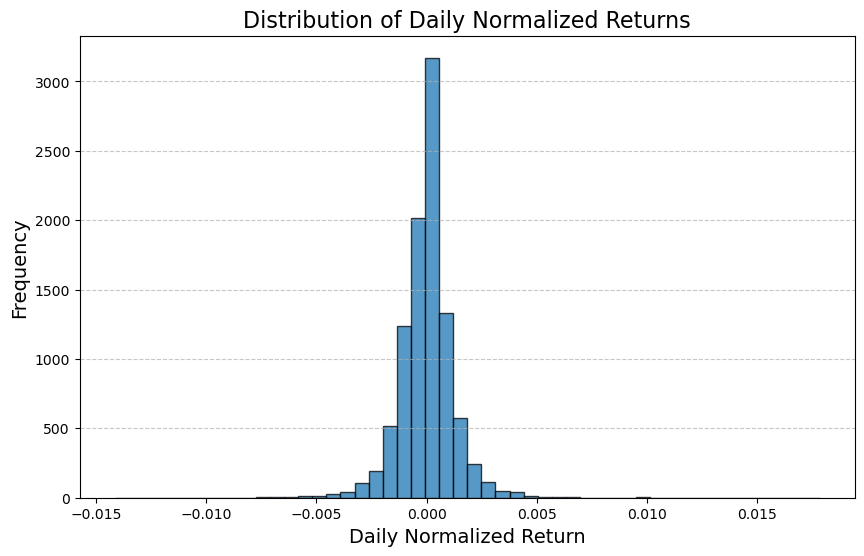

In [98]:
import matplotlib.pyplot as plt

# Plot the distribution of daily normalized returns
plt.figure(figsize=(10, 6))
plt.hist(df['normalized_return'], bins=50, alpha=0.75, edgecolor='black')
plt.title('Distribution of Daily Normalized Returns', fontsize=16)
plt.xlabel('Daily Normalized Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
df.columns

Index(['xltime', 'weighted_bid_price', 'total_bid_quantity',
       'max_bid_quantity', 'weighted_ask_price', 'total_ask_quantity',
       'max_ask_quantity', 'total_trade_volume', 'weighted_trade_price',
       'datetime', 'date', 'delta_time', 'log_return', 'normalized_return',
       'daily_normalized_return'],
      dtype='object')